In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm import *
import torch
import random
from pathlib import Path
from config import *
from utils import *
from lstm_utils import *

import numpy as np
import platform
import json

architecture='lstm'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_lstm_forecast_sl_30_run_2
num selection:1 - exp name:4_wheel_system_lstm_sl_16
num selection:2 - exp name:third_wheel_lstm_forecast_sl_16_run_1


In [3]:
select_exp = '0'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_lstm_forecast_sl_30_run_2


In [4]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm/4_wheel_system_lstm_forecast_sl_30_run_2/summary.csv


In [5]:
summary.reset_index().head(10)

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,19,13,"trainLSTM_6f7bf_00005_5_batch_size=100,embeddi...",51536,0.082132,0.090080
1,18,5,"trainLSTM_6f7bf_00016_16_batch_size=100,embedd...",51536,0.079612,0.090168
2,17,14,"trainLSTM_6f7bf_00004_4_batch_size=100,embeddi...",51536,0.077870,0.090340
3,16,3,"trainLSTM_6f7bf_00006_6_batch_size=100,embeddi...",34064,0.082032,0.090345
4,15,8,"trainLSTM_6f7bf_00017_17_batch_size=100,embedd...",34064,0.082032,0.090345
5,14,0,"trainLSTM_6f7bf_00018_18_batch_size=500,embedd...",51536,0.082358,0.090393
6,13,19,"trainLSTM_6f7bf_00015_15_batch_size=500,embedd...",51536,0.081626,0.090397
7,12,9,"trainLSTM_6f7bf_00010_10_batch_size=100,embedd...",67344,0.081149,0.090409
8,11,15,"trainLSTM_6f7bf_00002_2_batch_size=100,embeddi...",34064,0.081511,0.090414
9,10,6,"trainLSTM_6f7bf_00008_8_batch_size=500,embeddi...",51536,0.080631,0.090482


In [6]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'batch_size': 100, 'embedding_dim': 40, 'epochs': 200, 'lr': 0.0003, 'lr_patience': 5, 'n_layers_cell_1': 1, 'n_layers_cell_2': 1, 'seq_in_length': 30}


In [7]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [8]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [9]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=checkpoint['cfg']['dataset']['columns'],
columns_subset=cfg['dataset']['columns_subset'], dataset_subset=cfg['dataset']['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=cfg['dataset']['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)    

In [10]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 300
random shift 47925


In [11]:
inject_anomalies = False
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
if inject_anomalies:
    x, shift = unrolling_batches_with_anomalies(num_batch=num_batch, test_iter=test_iter, sigma=3,
                             sequence_length=params_conf['sequence_length'], cols=cfg.dataset.columns
                                                , shift = None)
else:
    x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=params_conf['sequence_length'], cols=cfg.dataset.columns
                                 , shift = None)

time horizon 300
random shift 57706


In [12]:
model = LSTM(seq_in=params_conf['sequence_length'], seq_out= params_conf['out_window']
              , n_features=params_conf['n_features'],
            output_size=params_conf["output_size"], embedding_dim=params_conf['embedding_dim'],
            n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

Encoder(
  (LSTMenc): LSTM(16, 80, batch_first=True)
  (LSTM1): LSTM(80, 40, batch_first=True)
  (out): Linear(in_features=40, out_features=16, bias=True)
)
number of params 51536


In [13]:
yo = model(x.to(device))

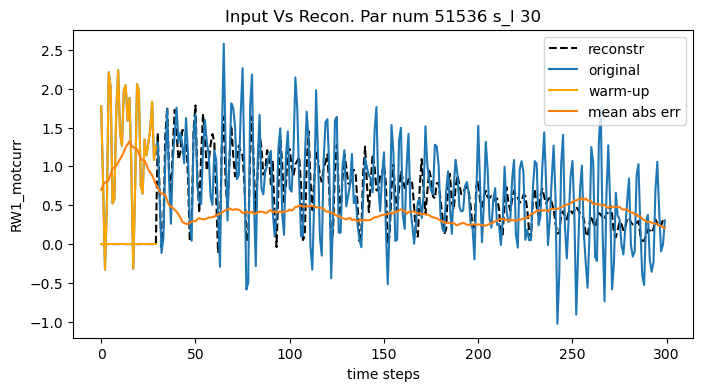

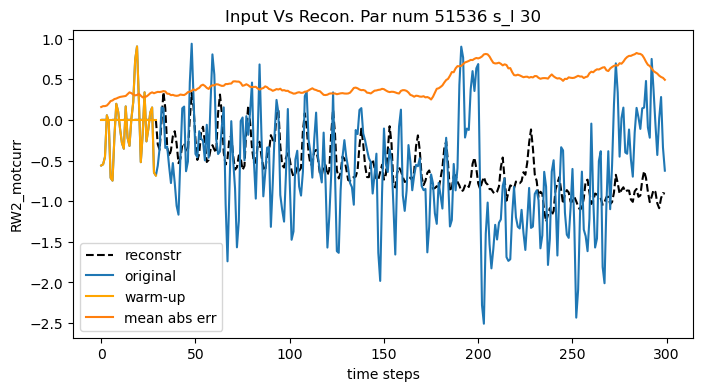

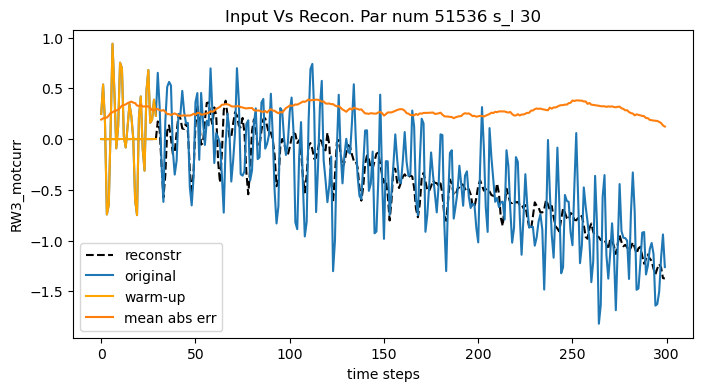

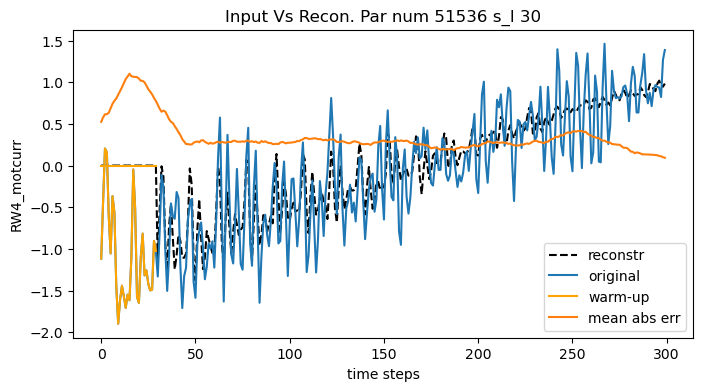

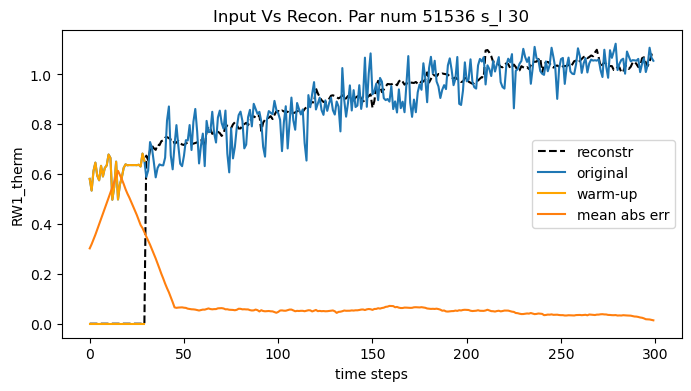

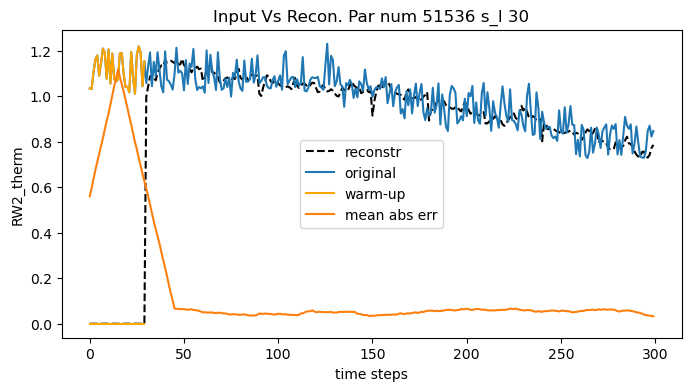

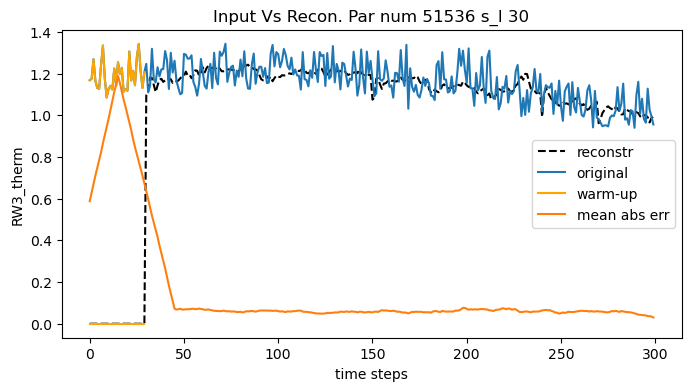

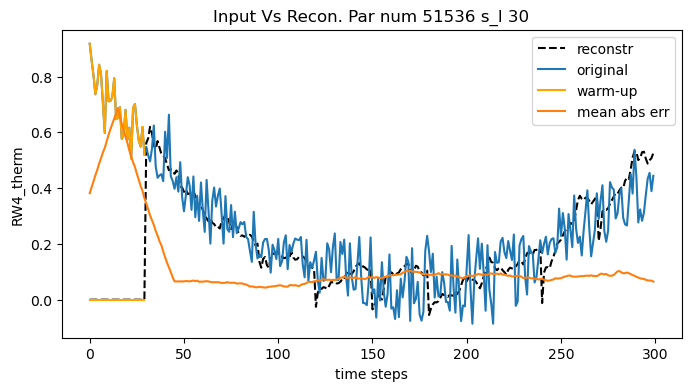

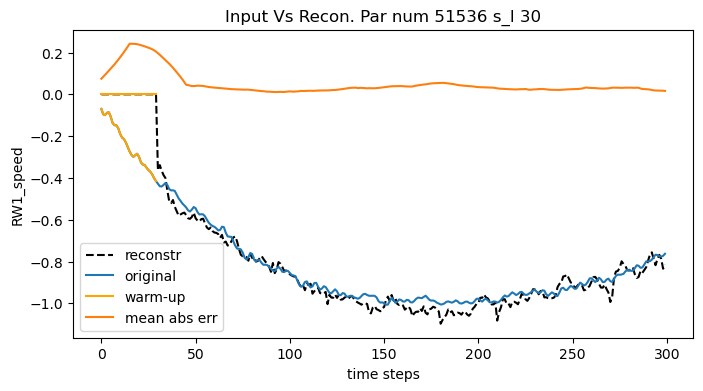

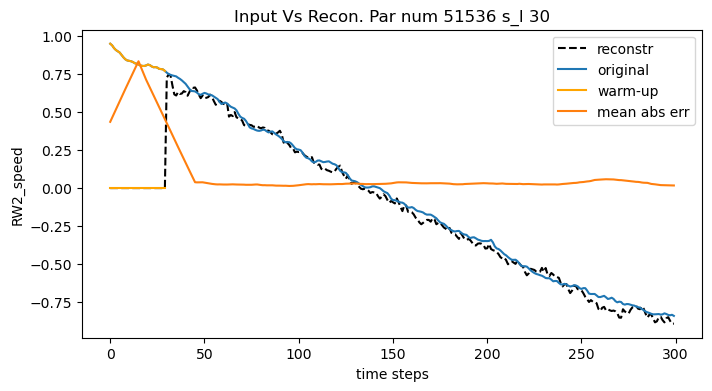

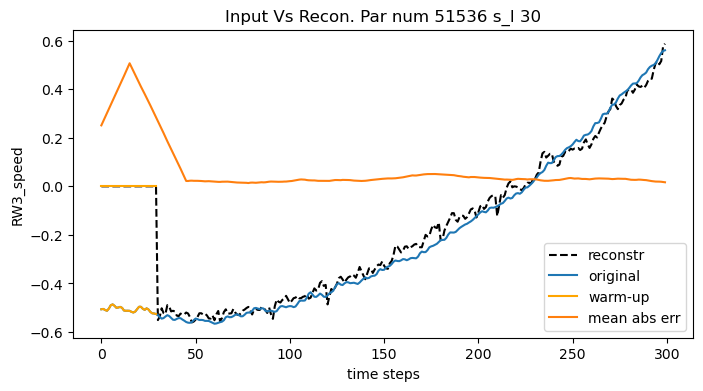

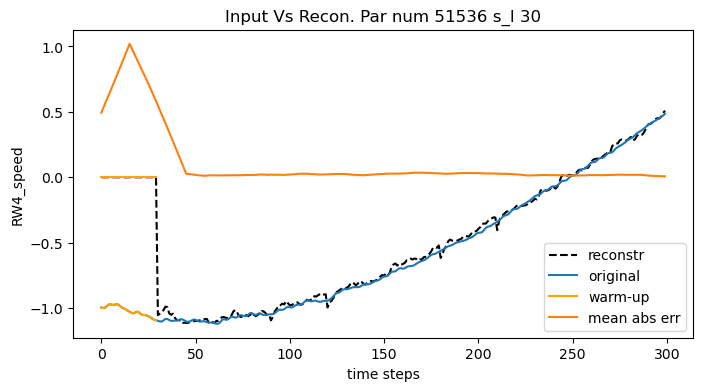

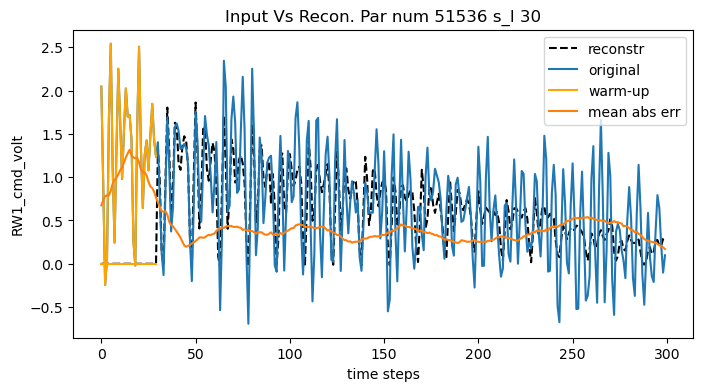

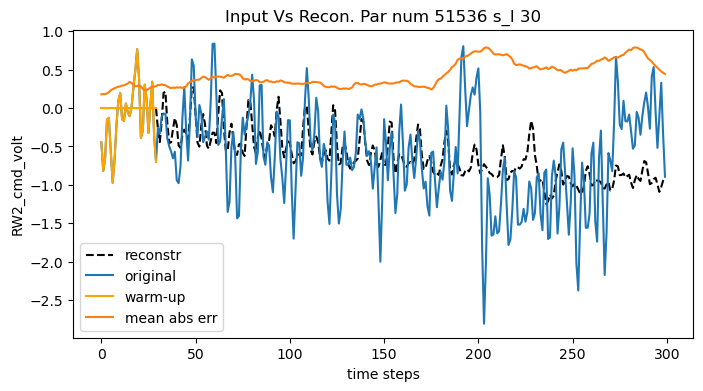

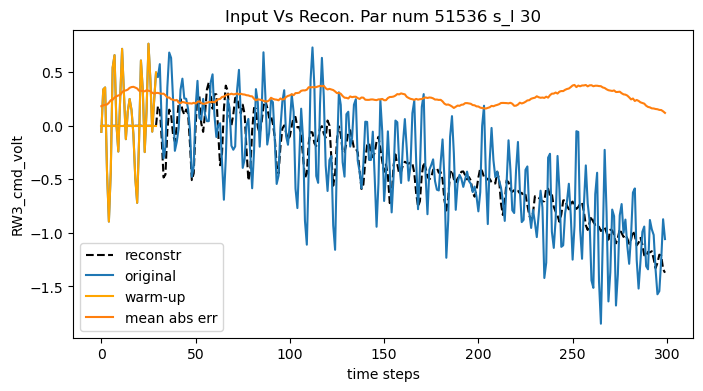

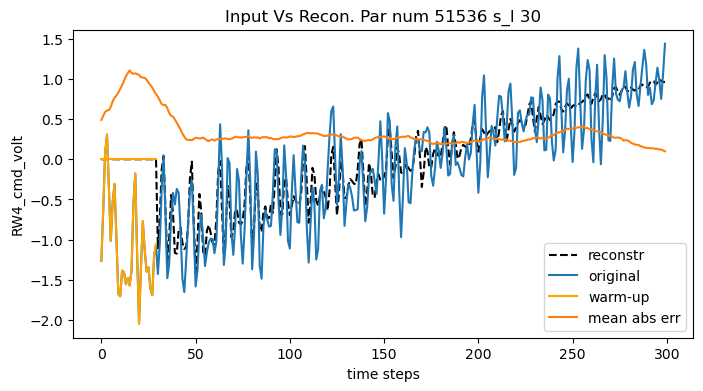

In [14]:
show_results(x.to(device),yo,cfg.dataset.columns,
    model_name,params_conf,par_nums,shift,
    num_batch,architecture='lstm',
    save=False)